<a href="https://colab.research.google.com/github/griffinArijit/Solar-Panel-Fault-Detection/blob/main/Solar_panel_fault_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Reading dataset**

In [3]:
temp = np.load('/content/drive/MyDrive/imgs_temp.npy')
mask = np.load('/content/drive/MyDrive/imgs_mask.npy')
check  = np.load('/content/drive/MyDrive/imgs_check.npy')

In [4]:
print('Temperature image:')
print(temp.shape)

Temperature image:
(1009, 512, 640)


In [5]:
print('Masked image:')
print(mask.shape)

Masked image:
(1009, 512, 640)


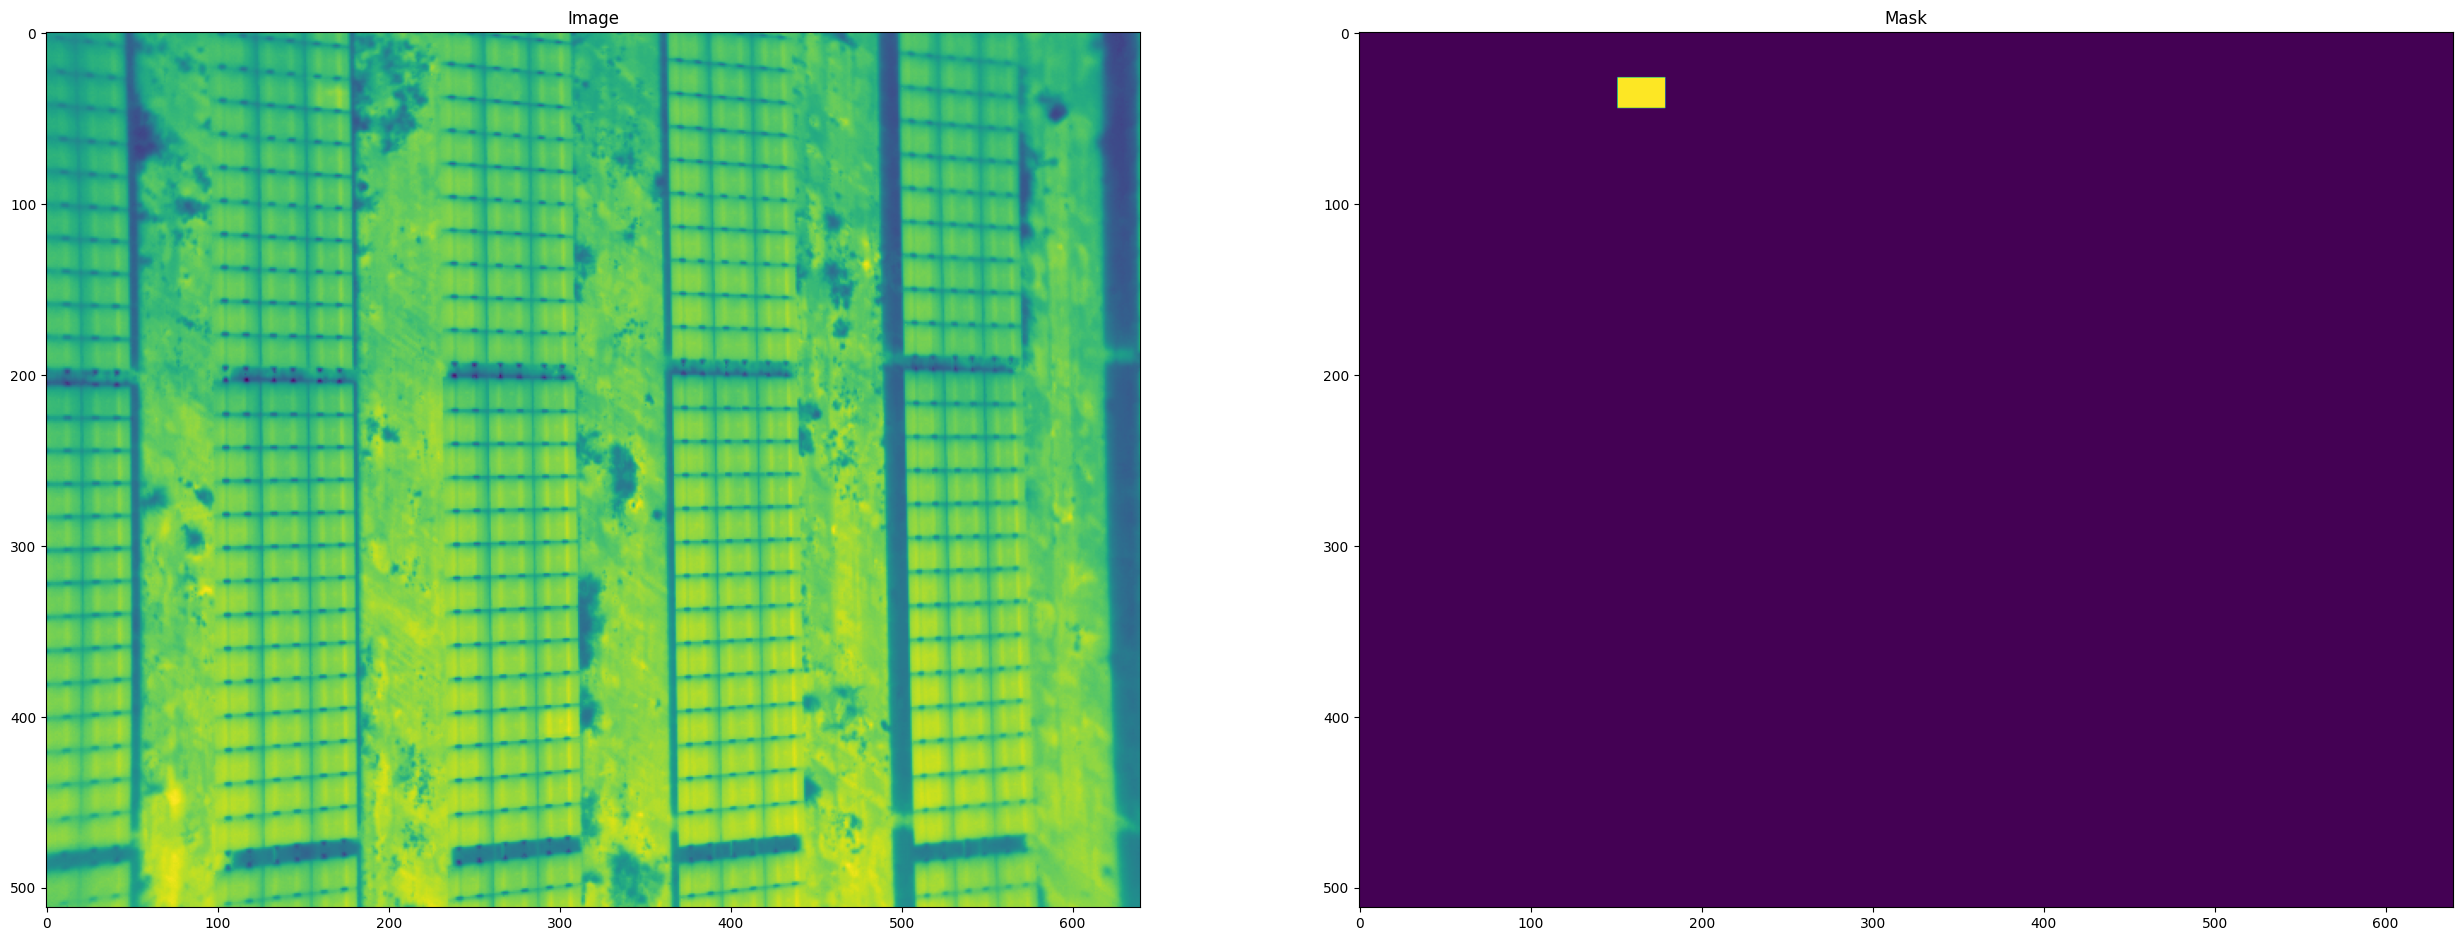

In [6]:
index=10
plt.figure(figsize=(48, 32))
plt.subplot(231)
plt.title('Image')
plt.imshow(temp[index])
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[index])

**Min-Max Normalization**

In [7]:
min_temp = np.min(temp)
max_temp = np.max(temp)
print('Minimum: '+ str(min_temp))
print('Maximum: '+ str(max_temp))

Minimum: 2.24999
Maximum: 103.33


In [8]:
temp = (temp - min_temp) / (max_temp - min_temp)

In [9]:
temp_image=[]
mask_image=[]

for image in temp:
  # Converting image to grayscale image and resize
  # Converting to rgb image for better performance

  img=(image*255).astype(np.uint8)
  hist, bins = np.histogram(img.flatten(), 256, [0, 256])
  cdf = hist.cumsum()
  # cdf_normalized = cdf * float(hist.max()) / cdf.max()
  cdf_m = np.ma.masked_equal(cdf, 0)
  cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
  cdf = np.ma.filled(cdf_m, 0).astype('uint8')
  mage = cdf[img]
  mage=cv2.cvtColor(mage,cv2.COLOR_GRAY2RGB)

  image2=cv2.resize(mage,(256,256))
  temp_image.append(image2)


for image in mask:
  #Resizing mask as temperature image
  image=cv2.resize(image,(256,256))
  mask_image.append(image)


temp_image=np.array(temp_image)
#temp_image=temp_image/255
mask_image=np.array(mask_image)

In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_image.shape
mask_dataset_reshaped = mask_image.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [11]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(1009, 256, 256, 1)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(temp_image, mask_dataset_encoded, test_size = 0.2, random_state = 0)

In [13]:
n_classes = 2
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [14]:
!pip install -U segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [15]:
 #Reused parameters in all models
import tensorflow
n_classes=2
activation='softmax'

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.3), sm.metrics.FScore(threshold=0.3)]

In [16]:
 ###Model
BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)


In [17]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model.summary())

44107200/44107200 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 40)       1080      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 40)       160       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='/content/drive/MyDrive/bestModel-{val_f1-score:.04f}.h5'
checkpoint = ModelCheckpoint(filepath,monitor='val_f1-score',varbose=1,save_best_only=True,mode='max')


In [19]:
history=model.fit(X_train_processed,
          y_train_cat,
          batch_size=5,
          epochs=30,
          verbose=1,
          callbacks=[checkpoint],
          validation_data=(X_test_processed, y_test_cat))


model.save('/content/drive/MyDrive/Colab Notebooks/fresh_model/efficiennet_backbone_n_epochs.hdf5')

Epoch 1/30
162/162 [==============================] - ETA: 0s - loss: 0.6069 - iou_score: 0.4849 - f1-score: 0.4938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


162/162 [==============================] - 131s 265ms/step - loss: 0.6069 - iou_score: 0.4849 - f1-score: 0.4938 - val_loss: 0.5705 - val_iou_score: 0.5003 - val_f1-score: 0.5027
Epoch 2/30
162/162 [==============================] - 38s 236ms/step - loss: 0.5324 - iou_score: 0.4998 - f1-score: 0.5016 - val_loss: 0.5213 - val_iou_score: 0.5165 - val_f1-score: 0.5321
Epoch 3/30
162/162 [==============================] - 37s 231ms/step - loss: 0.5023 - iou_score: 0.5414 - f1-score: 0.5752 - val_loss: 0.4881 - val_iou_score: 0.6109 - val_f1-score: 0.6719
Epoch 4/30
162/162 [==============================] - 33s 206ms/step - loss: 0.4287 - iou_score: 0.6217 - f1-score: 0.6897 - val_loss: 0.4222 - val_iou_score: 0.6558 - val_f1-score: 0.7275
Epoch 5/30
162/162 [==============================] - 35s 215ms/step - loss: 0.2592 - iou_score: 0.7165 - f1-score: 0.7958 - val_loss: 0.2582 - val_iou_score: 0.7090 - val_f1-score: 0.7859
Epoch 6/30
162/162 [==============================] - 33s 206ms/s

In [24]:
model.save_weights('my_model_weights.h5')

In [33]:
from keras.models import load_model
custom_objects = {
    "dice_loss_plus_1focal_loss": total_loss,
    "iou_score": sm.metrics.IOUScore,
    "f1-score": sm.metrics.FScore
}

new_model = load_model('/content/drive/MyDrive/bestModel-0.8326.h5', custom_objects=custom_objects)

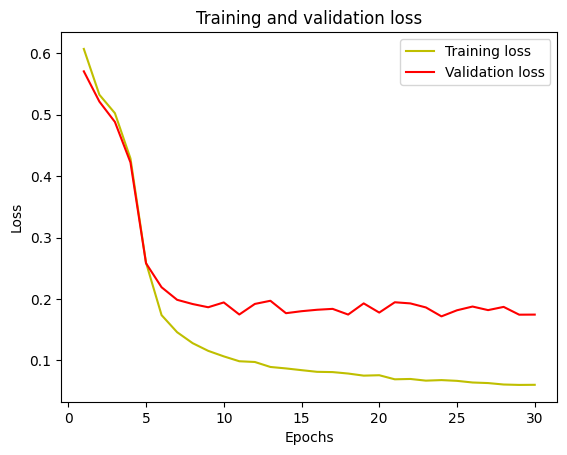

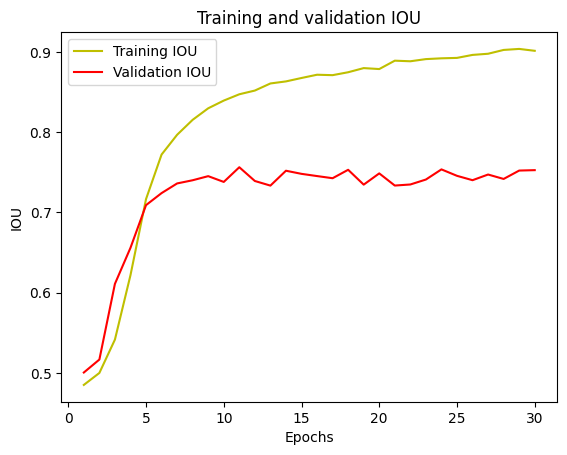

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [21]:
from keras.metrics import MeanIoU
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)

7/7 [==============================] - 17s 903ms/step


In [22]:
 #Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.73921895


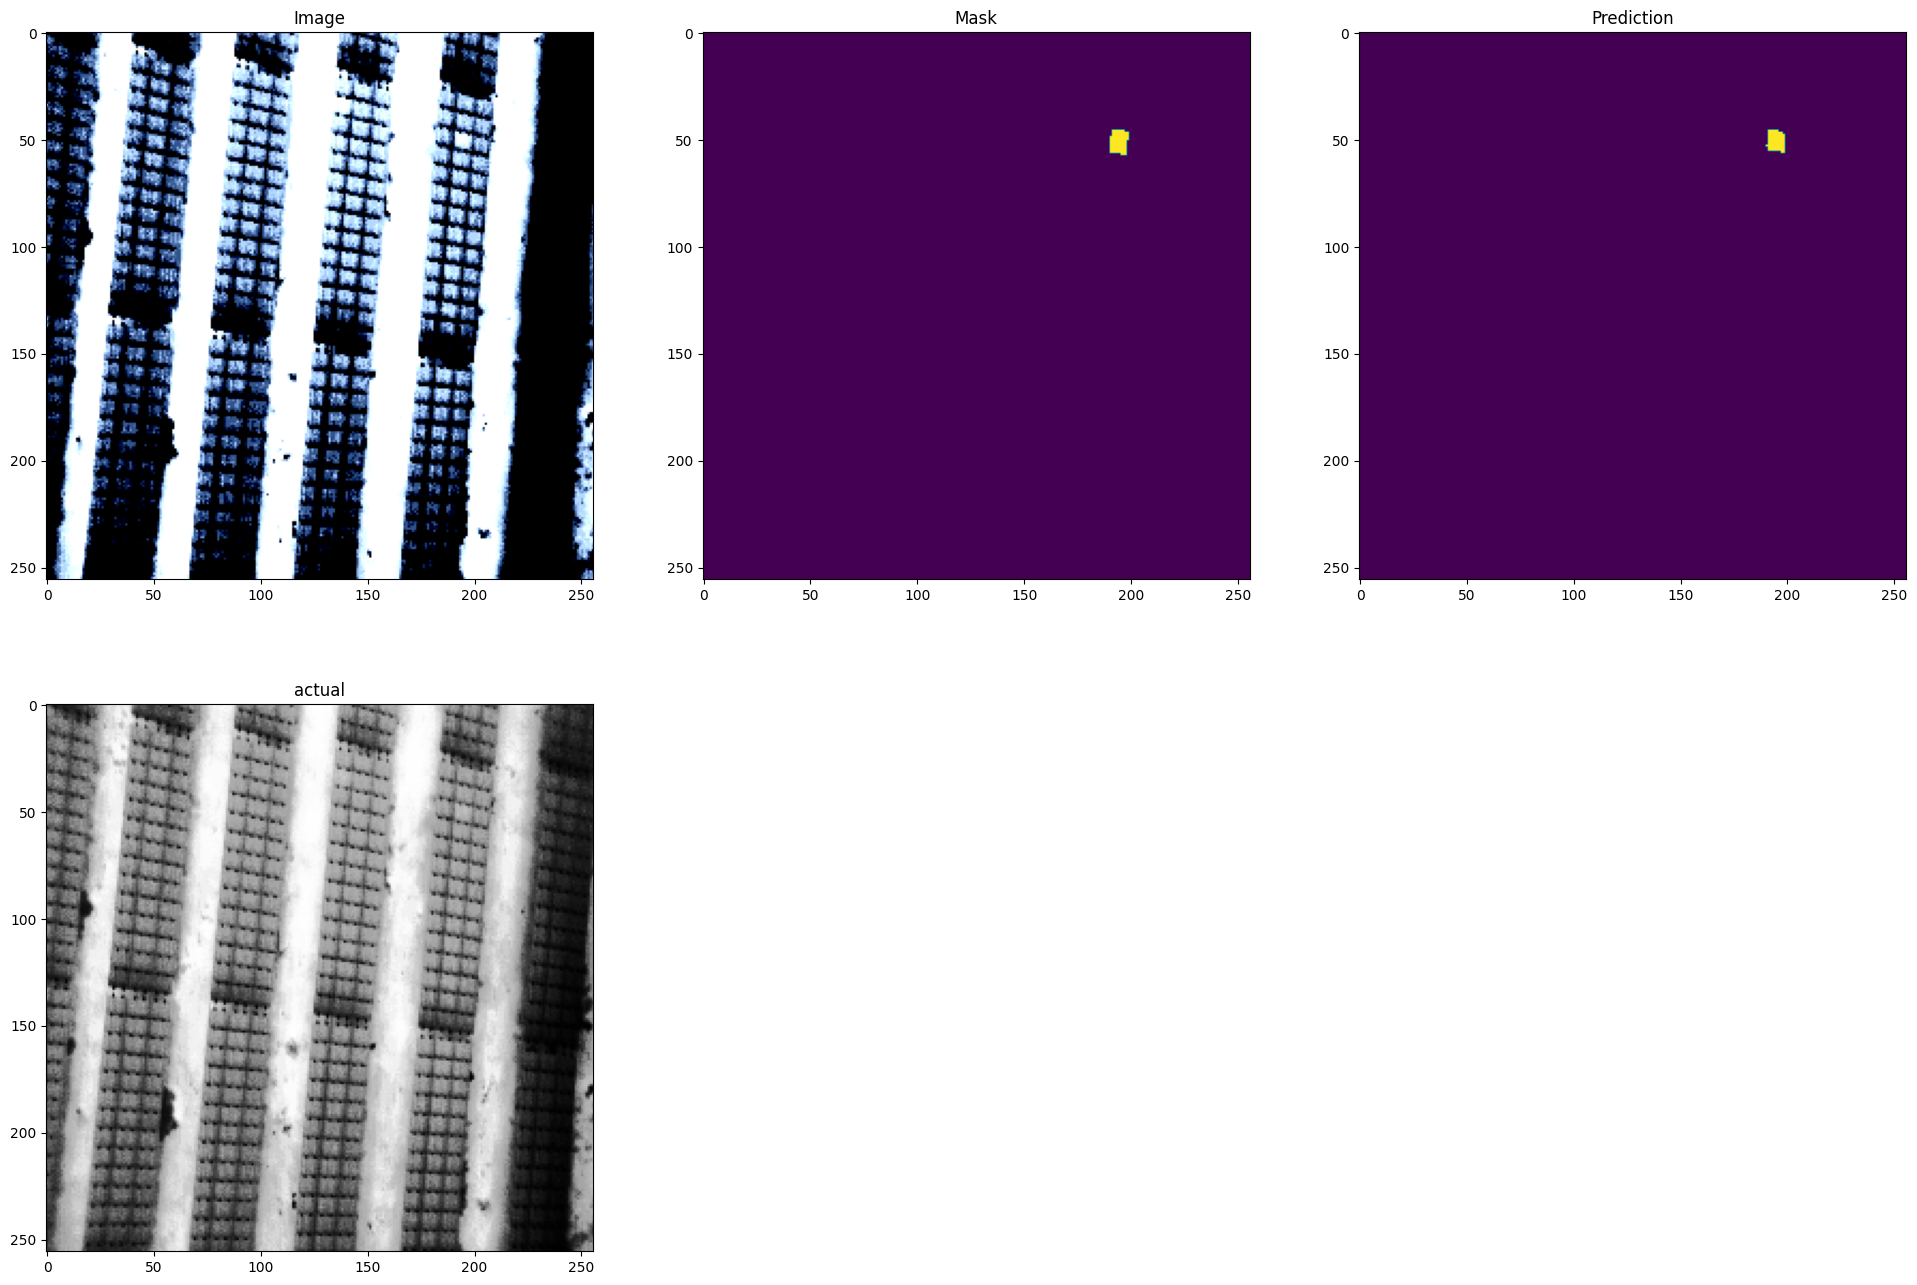

In [23]:
import random
img_number = random.randint(0, len(X_test_processed)-1)
img = X_test_processed[img_number]
imm = X_test[img_number]
# inn= temp[img_number]
mask = y_test[img_number]
prediction = y_pred_argmax[img_number]


plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Image')
plt.imshow(img)
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.subplot(234)
plt.title('actual')
plt.imshow(imm)
# plt.subplot(235)
# plt.title('actual')
# plt.imshow(inn)
plt.show()